In [5]:
import mysql.connector 
import config_aws
import requests
# import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
# import string # For the remove_special_chars function
import pandas as pd
from sodapy import Socrata
import sqlalchemy as db
import pandas as pd
# from helpers import (query, query_list)

In [6]:
#instantiate the connection and table

engine = db.create_engine(f'mysql+mysqlconnector://{config_aws.user}:{config_aws.pw}@{config_aws.host}/building_permits')

connection = engine.connect()
metadata=db.MetaData()

In [7]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

**Whitelist only the necessary columns:**

Dependent Variable:
- residential (Y, N)

Categorical:
- self_cert (Y, N, NA)
- zip_code - DROP
- borough (2)
- community_board (36)
- nonprofit (Y, N) likely correlated
- work_type (12 - categorized) now 'cat_work_type'
- job_type (A2, A3, A1, NB, DM, SG)
- permit_type (EW, PL, EQ, AL, NB, FO, SG, DM) # going to be correlated with job_type!
- permittee_liscense_type (GC, MP, FS, OB, SI, NW, OW, RA, PE)
- cat_owner_business_type  
- gis_nta_name (80 different location names, neighborhoods) DROP???
- owner_s_zip_code (2305 total values) - DROP?
- permit_sequence__ (29 options, number of a sequence type)
- gis_council_district (26 options)
- gis_census_tract (861 options) - DROP

Continuous:
- time_to_issuance (from filing_date, issuance_date)
- time_to_startdate (from job_start_date, issuance_date)

In [21]:
raw_data = query('SELECT self_cert, owner_s_business_type, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough FROM building_permits.dob_permits WHERE dob_permits.borough = "MANHATTAN"')

In [22]:
raw_data.head()

,self_cert,owner_s_business_type,non_profit,residential,job_type,work_type,gis_council_district,permittee_s_license_type,borough
0,N,CORPORATION,N,YES,A2,OT,4,GC,MANHATTAN
1,N,CONDO/CO-OP,N,YES,A2,MH,7,GC,MANHATTAN
2,N,CONDO/CO-OP,N,YES,A2,OT,7,GC,MANHATTAN
3,Y,PARTNERSHIP,N,No,A3,EQ,4,GC,MANHATTAN
4,N,CORPORATION,N,YES,A1,NA,3,GC,MANHATTAN


In [23]:
def cat_work(x):
    if x == 'OT':
        return 'Other'
    if x == 'PL':
        return 'Plumbing'
    if x == 'EQ':
        return 'Eqipment'
    if x == 'NA':
        return 'Other'
    if x == 'MH':
        return 'Mech'     
    if x == 'SP':
        return 'Internal'
    if x == 'BL':
        return 'Internal'
    if x =='SD':    
        return 'External'
    if x == 'FP':   #all 6 are fuel related
        return 'Fuel'
    if x == 'FB': 
        return 'Fuel'
    if x == 'FS':    
        return 'Fuel'
    if x == 'CC':
        return 'External'
    else:
        return 'Other'



In [24]:
def ob_type_categorize(x):
    if x == "CORPORATION":
        return 'Corp'
    if x == 'INDIVIDUAL':
        return 'Individual'
    if x == "CONDO/CO-OP":
        return 'Individual'
    if x == "OTHER GOV'T AGENCY":
        return 'Government'
    if x == "NYCHA/HHC":
        return 'Government'
    if x == "NYC AGENCY":
        return 'Government'
    if x == "NYCHA":
        return 'Government'
    if x == "HPD":
        return 'Government'
    if x == "DOE":
        return 'Government'
    if x == "HHC":
        return 'Government'
    if x == "DCAS":
        return 'Government'
    if x == "NY STATE":
        return 'Government'
    if x == "PARTNERSHIP":
        return 'Part_Other'
    if x == "OTHER":
        return 'Part_Other'
    else:
        return 'Part_Other'
   

In [26]:
def full_clean(data):
    
    #create new column 
#     data['time_to_issuance']=data['issuance_date'] - data['filing_date']
    
    #create new column
    data['cat_owner_business_type'] = data['owner_s_business_type'].map(lambda x: ob_type_categorize(x))
    
    data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
    
    data.drop(columns=['work_type', 'owner_s_business_type'], inplace=True)
    
    #create new column for 
#     data['time_to_startdate'] = data['issuance_date'] - data['job_start_date']
    
    return data

In [27]:
df = full_clean(raw_data)

In [30]:
# df =raw_data
df.head()
df.shape


(411098, 9)

In [29]:
#drop dependent variable
y = df['residential']
X = df.drop(columns='residential', axis=1)
# X.head()

**Train Test Split**

In [31]:
#train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
X_train.shape

(328878, 8)

**DummyClassifier** is a classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

In [55]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [56]:
dummy.score(X_test, y_test)  

0.5373996594502554

**One Hot Encode**

In [33]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [34]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Show:
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

,self_cert_NA,self_cert_Y,non_profit_Y,job_type_A2,job_type_A3,job_type_DM,job_type_NB,job_type_SG,gis_council_district_2,gis_council_district_3,...,permittee_s_license_type_SI,cat_owner_business_type_Government,cat_owner_business_type_Individual,cat_owner_business_type_Part_Other,cat_work_type_External,cat_work_type_Fuel,cat_work_type_Internal,cat_work_type_Mech,cat_work_type_Other,cat_work_type_Plumbing
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
#get column names from the dataframe
col_names = ohe_df.columns

In [47]:
X_train_ohe.shape

(328878, 102)

In [ ]:
from sklearn.dummy import DummyClassifier



**Decision Tree**

In [36]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='gini', max_depth = 5)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

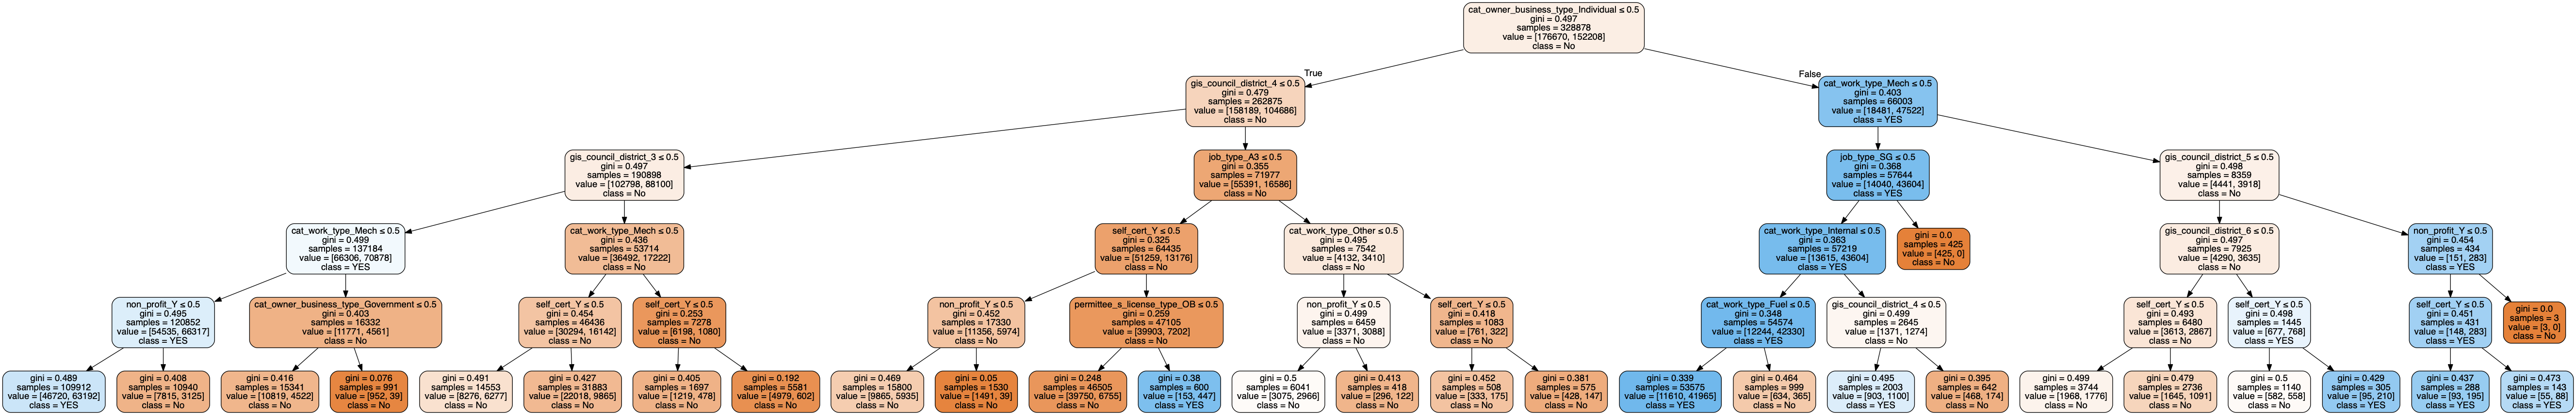

In [37]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

# graph
graph = graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [38]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.6813305765020676


In [54]:
type(X_test_ohe)
#using the columns from the onehot, make df

ValueError: Shape of passed values is (82220, 1), indices imply (82220, 102)

In [39]:
clf.feature_importances_

array([0.        , 0.04578103, 0.06920356, 0.        , 0.02808219,
       0.        , 0.        , 0.01661454, 0.        , 0.10060482,
       0.19181467, 0.00104372, 0.0006354 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01444977, 0.        , 0.        , 0.        , 0.        ,
       0.00411822, 0.37041672, 0.        , 0.        , 0.01161684,
       0.01478596, 0.12877712, 0.00205543, 0.        ])

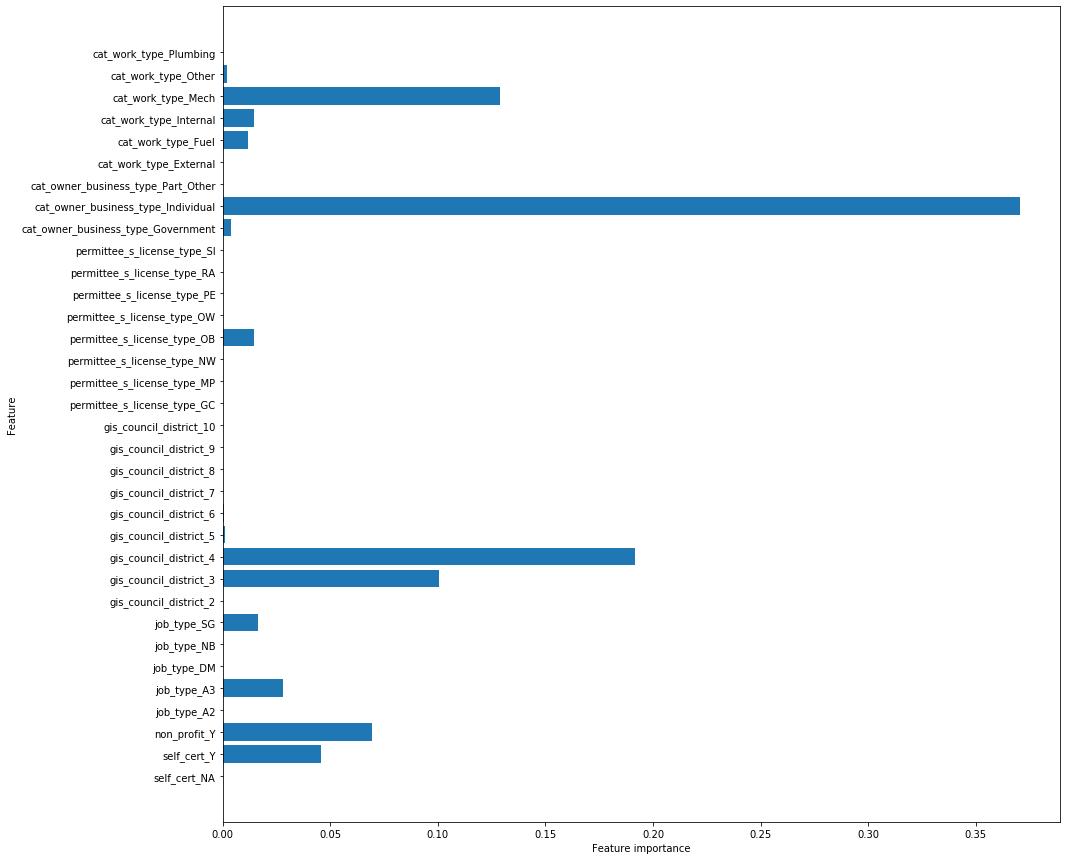

In [59]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
    n_features = X_train_ohe.shape[1]
    
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    
    plt.yticks(np.arange(n_features), col_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

Looks like the important features are:
- Individual Business type (DUH)
- Work type (mech, fuel, mech)
- City Council District 4 (midtown east, UES, Stytown)
- City Council District 3 (midtown west, Hudson Yards)
- Job Type - SG
- Job Type - A3
- Non Profit Yes (NYCHA?)
- Self Cert Yes (Landlords working on own buildings?)

**Confusion Matrix**

In [ ]:
#make X_test into a dataframe
#make Y_test into a dataframe

In [41]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first')

ohe.fit(X_test)
X_test_ohe = ohe.transform(X_test).toarray()

# Show:
ohe_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test.columns))
ohe_df.head()

,self_cert_NA,self_cert_Y,non_profit_Y,job_type_A2,job_type_A3,job_type_DM,job_type_NB,job_type_SG,gis_council_district_2,gis_council_district_3,...,permittee_s_license_type_SI,cat_owner_business_type_Government,cat_owner_business_type_Individual,cat_owner_business_type_Part_Other,cat_work_type_External,cat_work_type_Fuel,cat_work_type_Internal,cat_work_type_Mech,cat_work_type_Other,cat_work_type_Plumbing
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction = clf.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

[[29238 14947]
 [11254 26781]]
              precision    recall  f1-score   support

          No       0.72      0.66      0.69     44185
         YES       0.64      0.70      0.67     38035

    accuracy                           0.68     82220
   macro avg       0.68      0.68      0.68     82220
weighted avg       0.68      0.68      0.68     82220



**Random Forest**

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

Bagging Trees:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- n_estimators = The number of base estimators in the ensemble.

In [48]:
bagging_trees = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [49]:
bagging_trees.fit(X_train_ohe, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [64]:
y_predict = clf.predict(X_test_ohe)
y_predict

array(['No', 'No', 'YES', ..., 'No', 'YES', 'No'], dtype=object)

In [69]:
# Training accuracy score
bagging_trees.score(X_train_ohe, y_train)

0.6820006202908069

In [70]:
# Test accuracy score
bagging_trees.score(X_test_ohe, y_test)

0.6812819265385551

Fit to Random Forest

In [72]:
# Instantiate and fit a RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
random_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
# Training accuracy score
random_forest.score(X_train_ohe, y_train)

0.7108715085837302

In [75]:
# Test accuracy score
random_forest.score(X_test_ohe, y_test)

0.7098516176112868

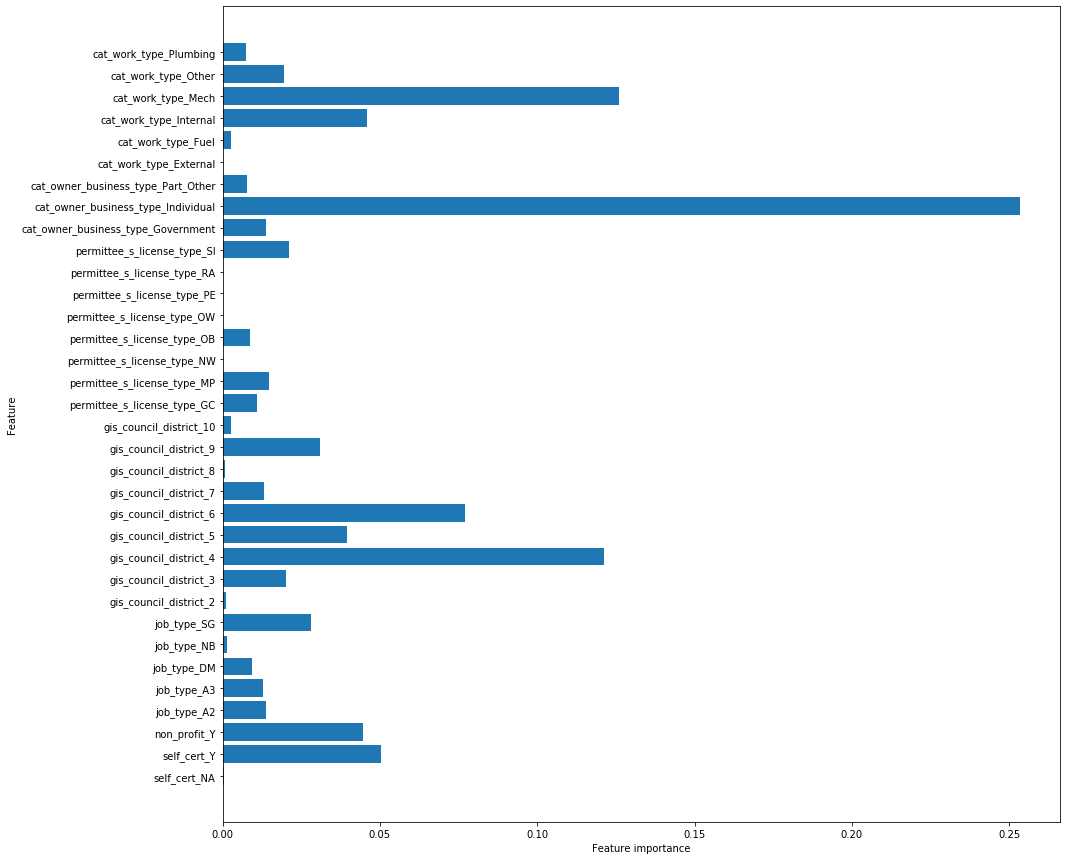

In [76]:
plot_feature_importances(random_forest)

Look at individual trees in the forest!

In [79]:
# Instantiate and fit a RandomForestClassifier
single_forest = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
single_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
# First tree from the forest!
tree_one = single_forest.estimators_[0]

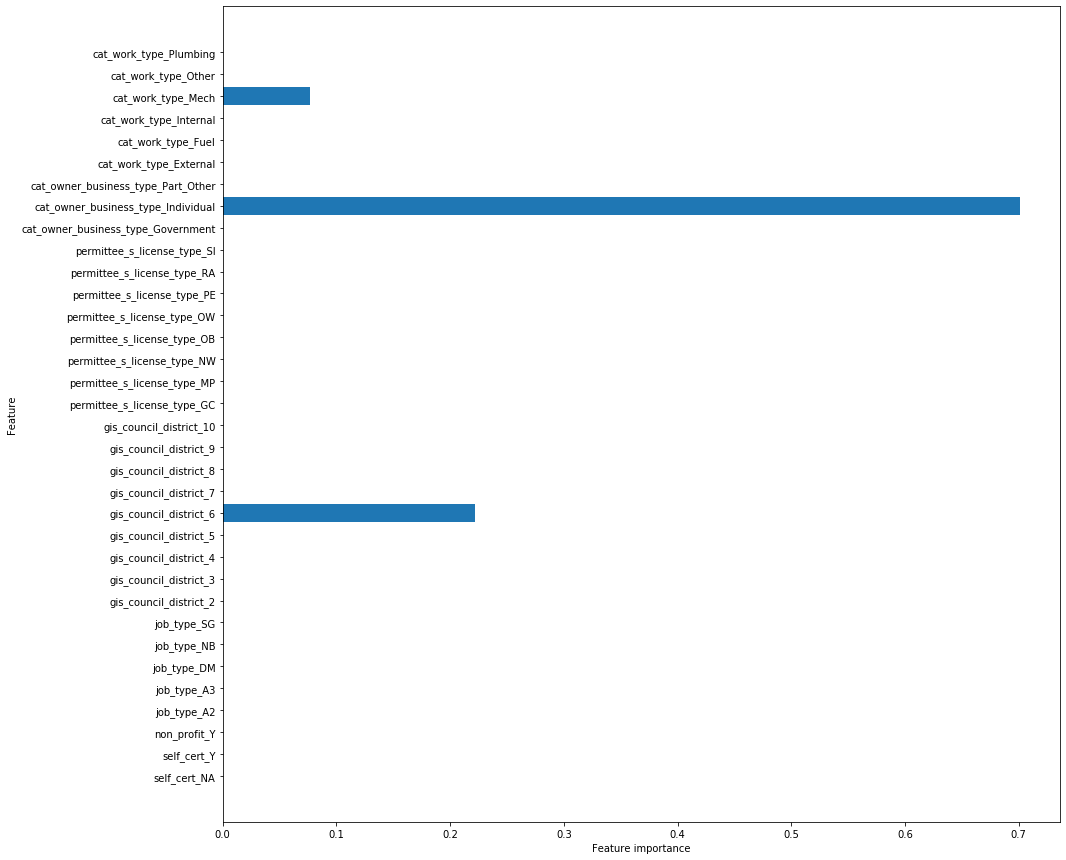

In [81]:
# Feature importance for this single tree
plot_feature_importances(tree_one)

In [82]:
# Second tree from forest
tree_two = single_forest.estimators_[1]

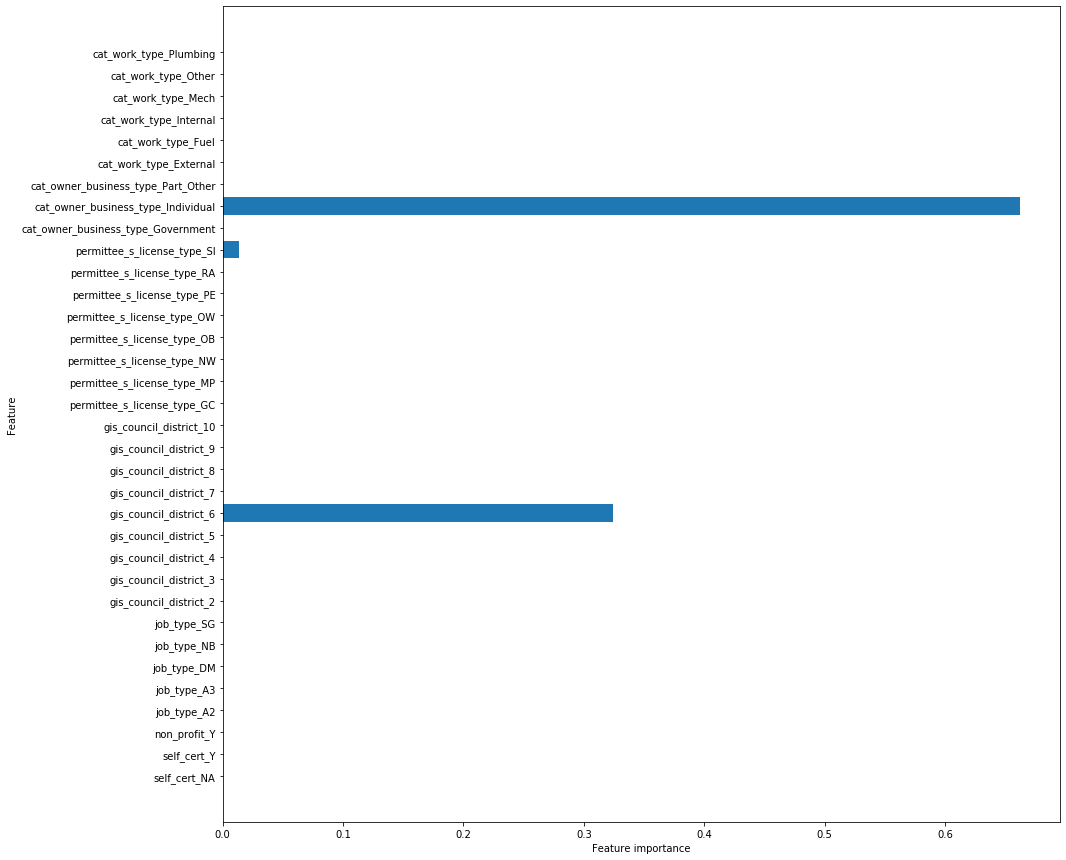

In [83]:
# Feature importance
plot_feature_importances(tree_two)